# Import Library

In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os

from copy import deepcopy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Labeling

In [3]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

# Membuat method create_df

In [4]:
def create_df(base):
    data = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            data["images"] += [img]
            data["labels"] += [label_index[i]]
    return pd.DataFrame(data)

# Membuat dataset

In [5]:
train_df = create_df('./data/train')
test_df = create_df('./data/test')
valid_df = create_df('./data/valid')

In [6]:
train_df = pd.concat([train_df, valid_df, test_df])

# Mendefinisikan training parameters

In [7]:
EPOCHS = 20
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [8]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [9]:
# Data latih
train_transform = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Resize((IMG_SIZE, IMG_SIZE)),
                            transforms.RandomVerticalFlip(0.6),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])])

# Validasi
transform = transforms.Compose([transforms.ToPILImage(),
                        transforms.ToTensor(),
                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

In [10]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [11]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [12]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [13]:
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Training Tools

In [15]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training

In [16]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04556349497946043 acc 0.4418881396271321 val loss 0.03857100993867905 acc 0.45714285714285713
Epochs 2 train loss 0.024858003048516607 acc 0.6541055136850457 val loss 0.033880816187177386 acc 0.5238095238095238
Epochs 3 train loss 0.016964575829178697 acc 0.7850059500198334 val loss 0.029339546816689627 acc 0.6222222222222222
Epochs 4 train loss 0.011837197994486012 acc 0.8591828639428798 val loss 0.03358867130582295 acc 0.6031746031746031
Epochs 5 train loss 0.008202078488080192 acc 0.9051963506545022 val loss 0.03277051354211474 acc 0.6476190476190476
Epochs 6 train loss 0.005710438050504054 acc 0.9401031336771123 val loss 0.023987002599807013 acc 0.7555555555555555
Epochs 7 train loss 0.003959645487616361 acc 0.961126537088457 val loss 0.0236079232087211 acc 0.7682539682539683
Epochs 8 train loss 0.0026860222115503893 acc 0.9722332407774693 val loss 0.026524797602305337 acc 0.7523809523809524
Epochs 9 train loss 0.001968998046172949 acc 0.9845299484331614 val l

# Performance log

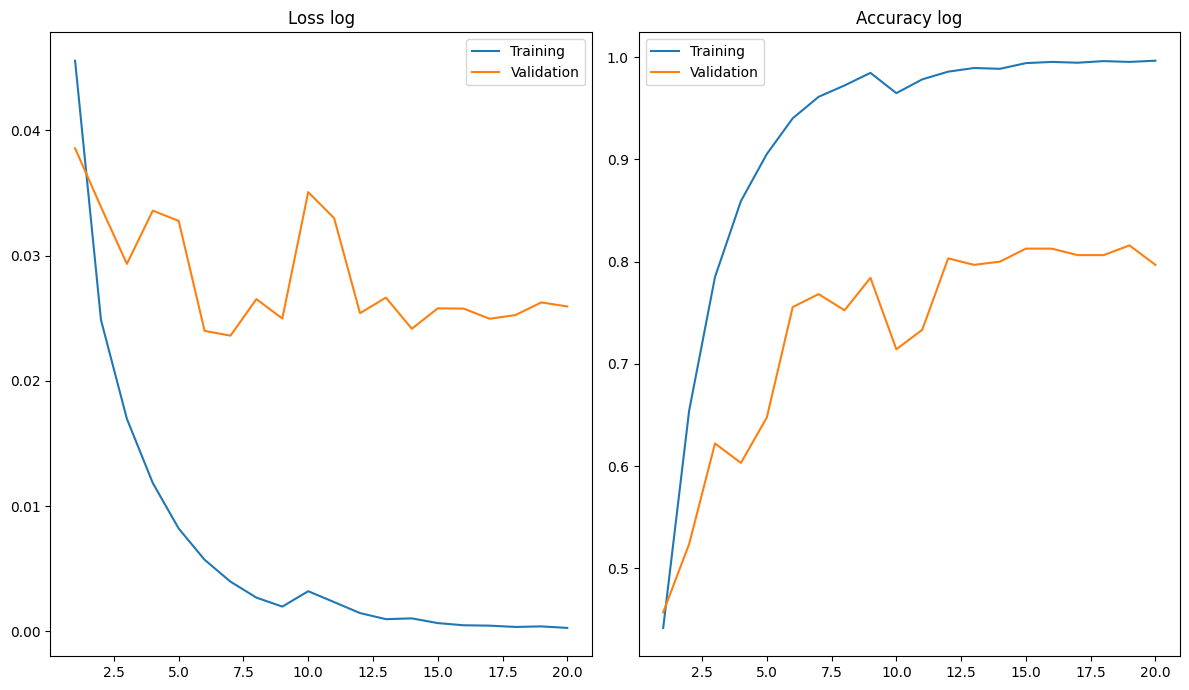

In [17]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [18]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [19]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

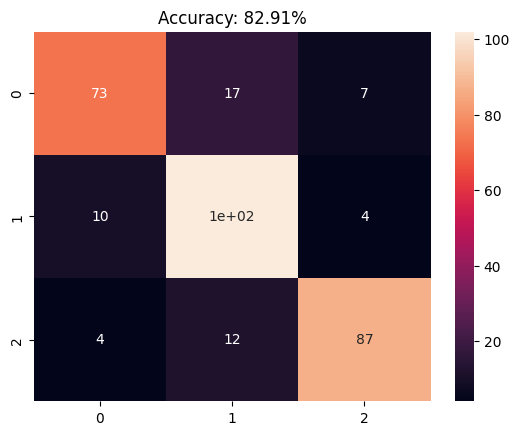

In [20]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [21]:
print(report)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        97
           1       0.78      0.88      0.83       116
           2       0.89      0.84      0.87       103

    accuracy                           0.83       316
   macro avg       0.84      0.83      0.83       316
weighted avg       0.83      0.83      0.83       316



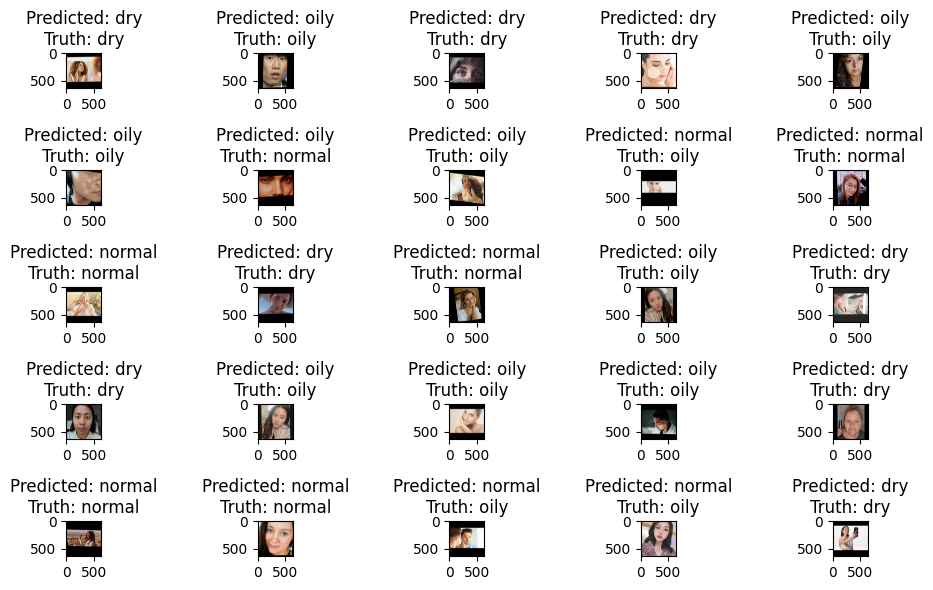

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()

In [24]:
torch.save(model.state_dict(), './model/model.pth')